In [1]:
!pip3 install transformers
!pip3 install evaluate
!pip3 install torch
!pip3 install protobuf==3.20.3
!pip3 install snscrape
!pip install transformers[torch]
!pip install accelerate -U
!pip install twscrape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. T

In [2]:
import csv
import os
from datetime import datetime
import asyncio
from twscrape import API, gather
from twscrape.logger import set_log_level
import nest_asyncio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline
from datasets import Dataset
import evaluate
from tqdm.notebook import tqdm
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TextClassificationPipeline
import evaluate


# **Data Collection**

In [ ]:
nest_asyncio.apply()
async def main():
    api = API("accounts.db")
    await api.pool.add_account("example1", "password123", "example1@gmail.com", "password123")
    await api.pool.add_account("example2", "password123", "example2@gmail.com", "password123")

    # await api.pool.add_account("MisterMohammed0", "009988Ppooii@@", "mohammedfoud30@gmail.com", "009988Ppooii@@")
    # await api.pool.add_account("mfoud2023", "009988Ppooii@@", "mfoud2023@gmail.com", "009988Ppooii@@")
    # await api.pool.add_account("mohammed_f14714", "009988Ppooii@@", "mfoud444@gmail.com", "009988Ppooii@@")
    await api.pool.login_all()
    set_log_level("DEBUG")


if __name__ == "__main__":
    asyncio.run(main())


In [ ]:
#Get list of accounts and their statuses
!twscrape accounts

In [ ]:
async def main():
    api = API("accounts.db")

    # Initialize CSV file
    csv_file_path = 'new.csv'
    fieldnames = [
        'id',   'created_at', 'lang', 'text', 'reply_count',   'hashtags','view_count', 'user_id', 'user_username', 'user_screen_name','user_followers_count', 'user_location'

    ]

    with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        query = '#SaudiCup   since:2024-02-20 until:2024-03-05 lang:en'
        async for tweet in api.search(query,  limit=5000):
            tweet_data = {
                'id': tweet.id,
                'created_at': tweet.date.isoformat(),
                'lang': tweet.lang,
                'text': tweet.rawContent,
                'reply_count': tweet.replyCount,
                'like_count': tweet.likeCount,
                'hashtags': ','.join(tweet.hashtags),
                'view_count': tweet.viewCount,
                'user_id': tweet.user.id,
                'user_username': tweet.user.username,
                'user_screen_name': tweet.user.displayname,
                'user_followers_count': tweet.user.followersCount,
                'user_location': tweet.user.location,

            }
            writer.writerow(tweet_data)


    set_log_level("DEBUG")

if __name__ == "__main__":
    asyncio.run(main())

## **Data  Visualization and Preprocessing**


In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
df.columns

Index(['id', 'created_at', 'lang', 'text', 'reply_count', 'hashtags',
       'view_count', 'user_id', 'user_username', 'user_screen_name',
       'user_followers_count', 'user_location'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4369 non-null   int64  
 1   created_at            4369 non-null   object 
 2   lang                  4369 non-null   object 
 3   text                  4369 non-null   object 
 4   reply_count           4369 non-null   int64  
 5   hashtags              3552 non-null   object 
 6   view_count            2528 non-null   float64
 7   user_id               4369 non-null   int64  
 8   user_username         4369 non-null   object 
 9   user_screen_name      4369 non-null   object 
 10  user_followers_count  4369 non-null   int64  
 11  user_location         3400 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 409.7+ KB


In [6]:
df.head()

,id,created_at,lang,text,reply_count,hashtags,view_count,user_id,user_username,user_screen_name,user_followers_count,user_location
0,1764704029517439394,2024-03-04T17:26:41+00:00,en,Take a glimpse back at the magnificent moments...,0,"SaudiCup,AlUlaFM,TheSoundOfArabia",147.0,1338426294753759235,AlUlaFm,AlUlaFM,3120,AlUla
1,1764558638423933184,2024-03-04T07:48:57+00:00,en,@Cristiano has been suspended for one match af...,0,"tejostudio,infomania,alnassr,ronaldo,SaudiCup,...",52.0,1717153253333307393,tejostudio2016,tejostudioofficial,10,NaN
2,1764258970665885858,2024-03-03T11:58:11+00:00,en,@thesaudicup @SALEH_ALSAMANI Love the enthusia...,0,SaudiCup,127.0,1484622917715607553,DonMalonee,A.G.,770,NewOrleansLouisvilleHouston
3,1763975245264789750,2024-03-02T17:10:46+00:00,en,🚨 BREAKING:\n\nAl Nassr will face Al Hilal in ...,0,"SaudiArabia,SaudiCup,AlNassr",138.0,1746665894674096129,S_CR7_Universe,🆂🅴🅷🅴🆁 07,420,Earth
4,1763934435756425652,2024-03-02T14:28:36+00:00,en,This is the #BestEverInHorseRacing #JuniorAlva...,0,"BestEverInHorseRacing,JuniorAlvarado,Family,Sa...",155.0,1678525767410393095,Saratogagirl444,Saratogagirl444,321,NaN


In [7]:
df.describe()

,id,reply_count,view_count,user_id,user_followers_count
count,4.369000e+03,4369.000000,2.528000e+03,4.369000e+03,4.369000e+03
mean,1.560793e+18,1.873426,1.109534e+04,5.363624e+17,3.931851e+04
std,2.312132e+17,20.199333,6.792742e+04,6.151949e+17,2.077884e+05
min,6.069281e+17,0.000000,1.000000e+00,2.566991e+06,0.000000e+00
25%,1.358768e+18,0.000000,1.420000e+02,2.421644e+08,5.910000e+02
50%,1.753413e+18,0.000000,5.110000e+02,2.871439e+09,2.910000e+03
75%,1.761415e+18,1.000000,3.137500e+03,1.147202e+18,2.018200e+04
max,1.803033e+18,1186.000000,2.044805e+06,1.787529e+18,5.207985e+06


In [8]:
df.dtypes

id                        int64
created_at               object
lang                     object
text                     object
reply_count               int64
hashtags                 object
view_count              float64
user_id                   int64
user_username            object
user_screen_name         object
user_followers_count      int64
user_location            object
dtype: object

In [9]:
unique_ids = df['id'].unique()

# display the total number of unique IDs
print(f"Total unique IDs: {len(unique_ids)}")


Total unique IDs: 3925


In [10]:
# remove duplicates data
df = df.drop_duplicates(subset='id', keep='first')

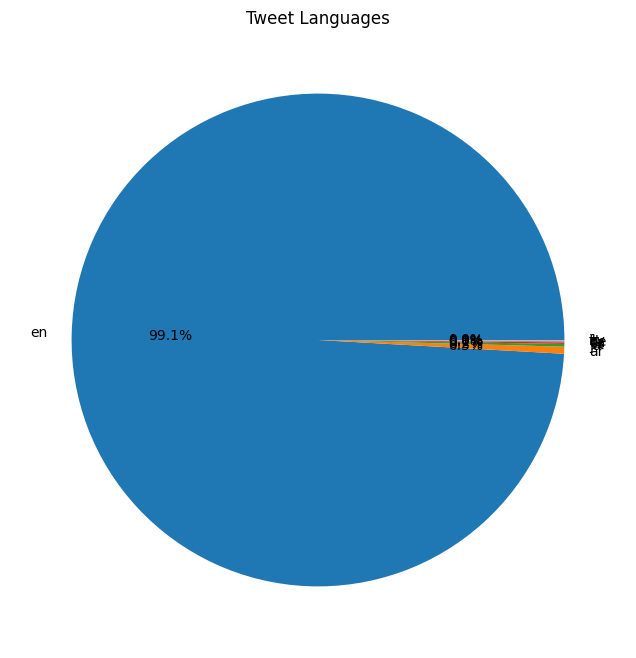

In [11]:
#  Pie chart of tweet languages
lang_counts = df['lang'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%')
plt.title('Tweet Languages')
plt.show()

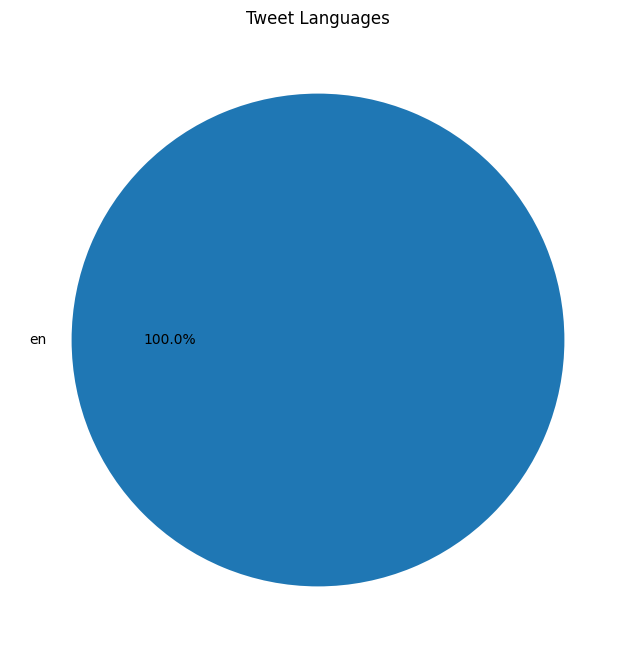

In [12]:
#  Keep only English language tweets and Pie chart of tweet languages
df = df[df['lang'] == 'en']
lang_counts = df['lang'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%')
plt.title('Tweet Languages')
plt.show()

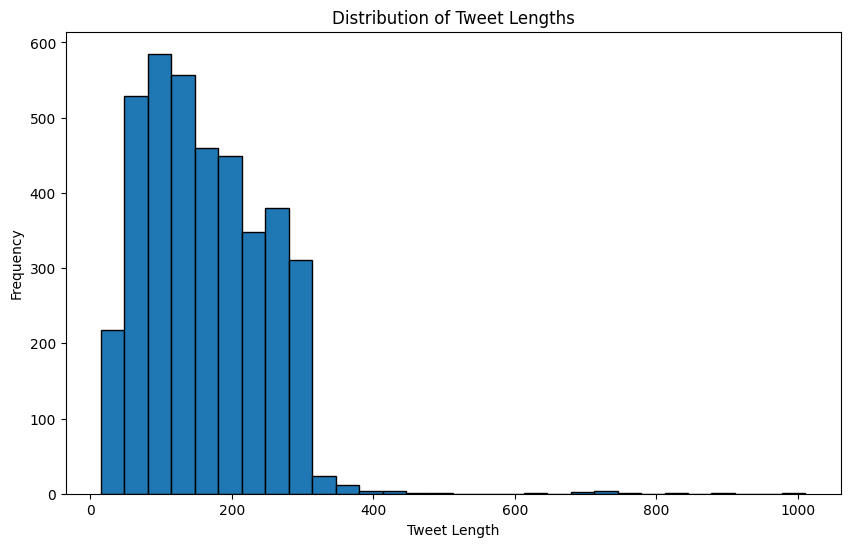

In [13]:
#  Histogram of tweet lengths
tweet_lengths = df['text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=30, edgecolor='black')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.show()

In [ ]:

# Convert 'created_at' column to datetime format
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')


#  Line plot of tweet count over time
df['created_at'] = pd.to_datetime(df['created_at'])
tweet_counts = df.resample('D', on='created_at').size()
plt.figure(figsize=(12, 6))
plt.plot(tweet_counts.index, tweet_counts)
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.title('Tweet Count Over Time')
plt.xticks(rotation=45)
plt.show()

ValueError: time data "2024-03-04T17:26:41+00:00" doesn't match format "%a %b %d %H:%M:%S %z %Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

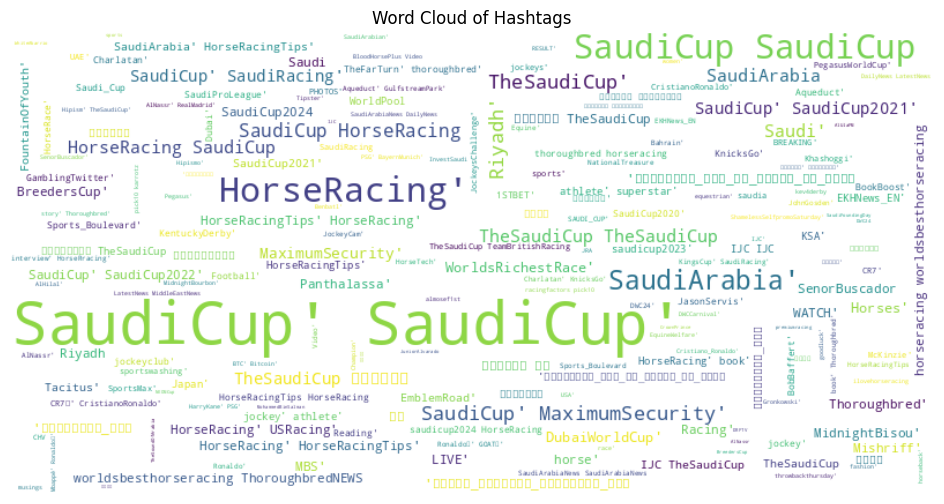

In [ ]:
hashtags = df['hashtags'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hashtags)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hashtags')
plt.show()

In [15]:
# Fill missing values in 'user_location' with 'Unknown'
df['user_location'] = df['user_location'].fillna('Unknown')

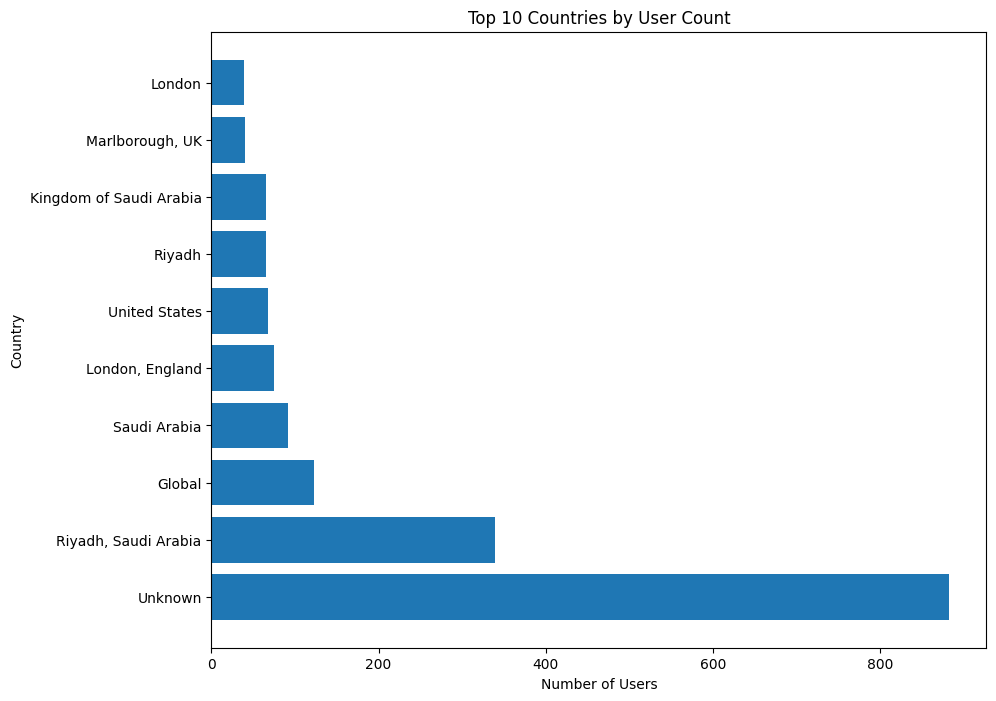

In [16]:
# Horizontal bar plot of top 10 countries by user count
user_country_counts = df['user_location'].value_counts().nlargest(10)
plt.figure(figsize=(10, 8))
plt.barh(user_country_counts.index, user_country_counts)
plt.xlabel('Number of Users')
plt.ylabel('Country')
plt.title('Top 10 Countries by User Count')
plt.show()

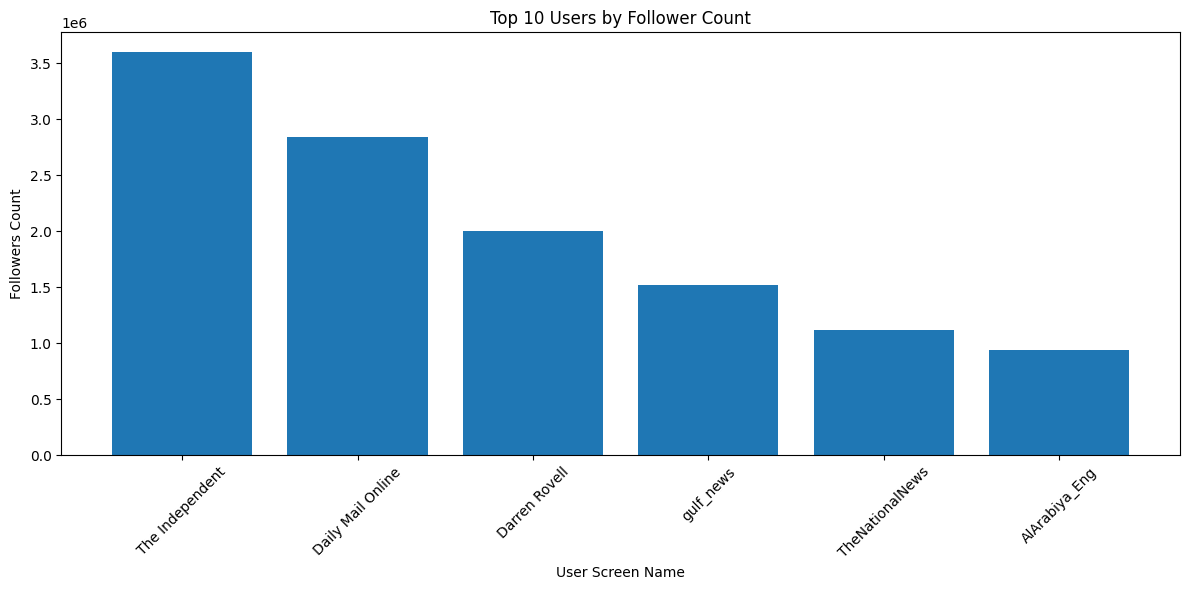

In [17]:
# Data Visualization : Bar plot of top 10 users by follower count
top_users = df.nlargest(10, 'user_followers_count')
plt.figure(figsize=(12, 6))
plt.bar(top_users['user_screen_name'], top_users['user_followers_count'])
plt.xlabel('User Screen Name')
plt.ylabel('Followers Count')
plt.title('Top 10 Users by Follower Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Sentiment Analysis**

In [18]:
!wget https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

--2024-06-28 17:11:18--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  36.5MB/s    in 2.1s    

2024-06-28 17:11:20 (36.5 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [19]:
class DataLoader():

    def import_tweets(self, path, cols=[0, 5]):
        self.tweets_df = pd.read_csv(path, usecols=cols, names=["label", "text"], encoding='latin-1')
        self.num_tweets = self.tweets_df.shape[0]

        self.tweets_df["text"] = self.tweets_df["text"].astype(str)
        self.tweets_df["label"] = self.tweets_df["label"].astype(str)

        return self.tweets_df

    def split_tweets(self, train_size, test_size):
        self.tweets_train, self.tweets_test = train_test_split(self.tweets_df, train_size=train_size, test_size=test_size)
        return self.tweets_train, self.tweets_test

In [20]:
class TwitterSentimentClassifier():

    def __init__(self, model_name='google-bert/bert-base-uncased', num_labels=2, label2int={"0":0, "4":1}, train_size=100000, test_size=10000):
        self.model_name = model_name
        self.num_labels = num_labels
        self.train_size = train_size
        self.test_size = test_size
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.label_to_int = label2int
        self.metric_accuracy = evaluate.load("accuracy")
        self.metric_precision = evaluate.load("precision")
        self.metric_recall = evaluate.load("recall")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def tokenize_function(self, batch):
        tokenized_batch = self.tokenizer(batch["text"], padding='max_length', truncation=True, max_length=140)
        tokenized_batch["label"] = [self.label_to_int.get(label, None) for label in batch["label"]]
        return {k: v for k, v in tokenized_batch.items() if k != "label" or v is not None}

    def import_tweets(self, path):
        dl = DataLoader()
        dl.import_tweets(path)
        self.train, self.test = dl.split_tweets(self.train_size, self.test_size)

        self.train = Dataset.from_pandas(self.train)
        self.test = Dataset.from_pandas(self.test)

        self.train_dataset = self.train.map(self.tokenize_function, batched=True)
        self.test_dataset = self.test.map(self.tokenize_function, batched=True)

    def get_metrics(self, predictions, labels):
        accuracy = self.metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
        precision = self.metric_precision.compute(predictions=predictions, references=labels)["precision"]
        recall = self.metric_recall.compute(predictions=predictions, references=labels)["recall"]
        f1_score = 2 * (precision * recall) / (precision + recall)

        return {"accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1_score}

    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return self.get_metrics(predictions, labels)

    def train_model(self):
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels)
        self.model.to(self.device)
        self.training_args = TrainingArguments(
            report_to="none",
            output_dir="training_arguments",
            save_strategy="no",
            evaluation_strategy="epoch",
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            learning_rate=3e-5,
            weight_decay=0.01,
            num_train_epochs=3,
        )

        self.trainer = Trainer(
            model=self.model,
            args=self.training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.test_dataset,
            compute_metrics=self.compute_metrics,
        )

        self.trainer.train()

    def save_model_local(self, path):
        self.trainer.save_model(path)

    def save_model_cloud(self):
        raise NotImplementedError("not currently implemented")

    def load_saved_model(self, path):
        self.model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=self.num_labels)
        self.model.to(self.device)
        self.pipe = TextClassificationPipeline(model=self.model, tokenizer=self.tokenizer, device=0 if self.device.type == "cuda" else -1)

    def get_scores(self, text):
        return self.pipe(text)

    def predict_dataset(self, dataset_path, batch_size=32):
        # Load the dataset
        df = pd.read_csv(dataset_path)

        # Ensure there's a 'text' column
        if 'text' not in df.columns:
            raise ValueError("The dataset must contain a 'text' column")

        # Make predictions in batches
        predictions = []
        for i in tqdm(range(0, len(df), batch_size), desc="Predicting"):
            batch = df['text'][i:i+batch_size].tolist()
            batch_predictions = self.predict(batch)
            predictions.extend(batch_predictions)

        # Add predictions to the dataframe
        df['predicted_sentiment'] = predictions

        # Map numeric predictions back to labels
        label_map = {0: "Negative", 1: "Positive"}
        df['predicted_sentiment_label'] = df['predicted_sentiment'].map(label_map)

        return df

    def predict(self, text):
        if isinstance(text, str):
            text = [text]

        inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=140, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)

        return predictions.cpu().numpy().tolist()

    def evaluate_model(self, path, cols=[0, 5]):
        dl = DataLoader()
        dl.import_tweets(path, cols=cols)

        # Filter out rows with labels not in label_to_int
        dl.tweets_df = dl.tweets_df[dl.tweets_df['label'].isin(self.label_to_int.keys())]

        self.eval = Dataset.from_pandas(dl.tweets_df)
        self.eval_dataset = self.eval.map(self.tokenize_function, batched=True)

        predictions = np.array(self.predict(self.eval_dataset["text"]))
        labels = np.array(self.eval_dataset["label"])

        return self.get_metrics(predictions, labels)

In [21]:
ts = TwitterSentimentClassifier()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
dataFile = 'training.1600000.processed.noemoticon.csv'


ts.import_tweets(dataFile)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [23]:
ts.train_model()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.354000,0.357338,0.849500,0.875053,0.817459,0.845276
2,0.253100,0.358621,0.857800,0.859335,0.857626,0.858479
3,0.154300,0.460958,0.853800,0.858637,0.849075,0.853829


In [24]:
ts.save_model_local("twitter-sentiment")

In [31]:
# mount it
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [32]:
# copy model to drive
!cp -r /content/twitter-sentiment /content/drive/MyDrive

In [30]:
!zip -r twitter-sentiment.zip  twitter-sentiment

  adding: twitter-sentiment/ (stored 0%)
  adding: twitter-sentiment/config.json (deflated 48%)
  adding: twitter-sentiment/model.safetensors (deflated 7%)
  adding: twitter-sentiment/training_args.bin (deflated 51%)


Load Model

In [25]:
ts.load_saved_model("twitter-sentiment")

Evaluate

In [26]:
ts.evaluate_model("testdata.manual.2009.06.14.csv")

Parameter 'function'=<bound method TwitterSentimentClassifier.tokenize_function of <__main__.TwitterSentimentClassifier object at 0x7898c45fe350>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/359 [00:00<?, ? examples/s]

{'accuracy': 0.8384401114206128,
 'precision': 0.8263157894736842,
 'recall': 0.8626373626373627,
 'f1': 0.8440860215053764}

Prediction on Saudi Horse Cup tweets dataset

In [33]:
def preprocess_text(text):
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove commas
    text = text.replace(',', '')

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)



    # Remove extra spaces
    text = ' '.join(text.split())

    return text.strip()


df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(preprocess_text)

In [ ]:
df.to_csv("dataset_preprocess.csv", index=False)

In [39]:
results_df_preprocess = ts.predict_dataset("dataset_preprocess.csv")



# If you want to save the results
results_df_preprocess.to_csv("predictions_output_preprocess.csv", index=False)

Predicting: 100%|██████████| 122/122 [00:29<00:00,  4.16it/s]


In [40]:
sentiment_counts = results_df_preprocess['predicted_sentiment_label'].value_counts()
sentiment_counts

predicted_sentiment_label
Positive    3086
Negative     804
Name: count, dtype: int64

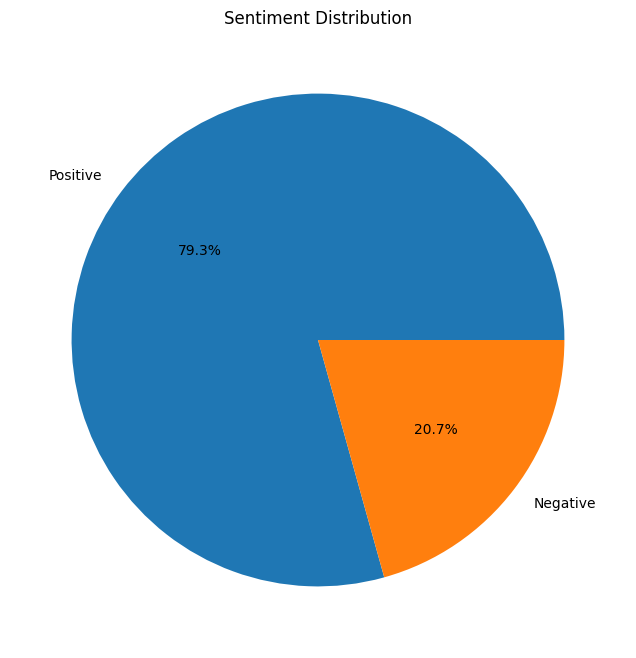

In [41]:
# Pie chart of sentiment distribution
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()